# Fake 3d maps with fake seeing/non-periodic 

+ Load and investigate the effect on the structure function


In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
import numpy as np
import json
import cmasher as cmr
from matplotlib import pyplot as plt
import seaborn as sns
import sys

import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_ppv
from spectral_cube import SpectralCube  

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc

sns.set_color_codes()
sns.set_context("talk")

In [3]:
widths = [1, 2, 4, 8, 16, 32]
vmaps = [0, 1, 2, 3]
r0 = 32.0
N = 256
m = 1.0

In [4]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

Load Non-periodic non-tapered non-smoothed structure function

In [5]:
#sfs_np = {}
#for i in range(0,4,1):
#    sfs_np[i] = values2arrays(json.load(open("fake-non-tapered-3d-nonp-nn-s0-000-0" + str(i) + "-strucfunc.json")))

In [6]:
sfs_np = {
        0 : [
            values2arrays(json.load(open(fn)))
            for fn in sorted(
                Path(".").glob(f"fake-non-tapered-3d-ems-fluc_m4-nonp-s0-000-*-strucfunc.json")
            )
        ]
        for vmap in vmaps
    }

In [7]:
mask = sfs_np[0][0]['N pairs']> 0

In [8]:
r = 10**sfs_np[0][0]['log10 r'][mask]

Load Non-periodic tapered non-smoothed structure function

In [9]:
#sfs_npt = {}
#for i in range(0,4,1):
#    sfs_npt[i] = [values2arrays(json.load(open("fake-tapered-3d-nonp-nn-s0-000-0" + str(i) + "-strucfunc.json"))) ]

In [10]:
sfs_npt = {
        0 : [
            values2arrays(json.load(open(fn)))
            for fn in sorted(
                Path(".").glob(f"fake-tapered-3d-ems-fluc_m4-nonp-s0-000-*-strucfunc.json")
            )
        ]
        for vmap in vmaps
    }

Load Non-periodic tapered smoothed structure function

In [11]:
sfs_npt_s = {
        width: [
            values2arrays(json.load(open(fn)))
            for fn in sorted(
                Path(".").glob(f"fake-tapered-3d-ems-fluc_m4-nonp-s0-{width:03d}-*-strucfunc.json")
            )
        ]
        for width in widths
    }

Plots

[None, None]

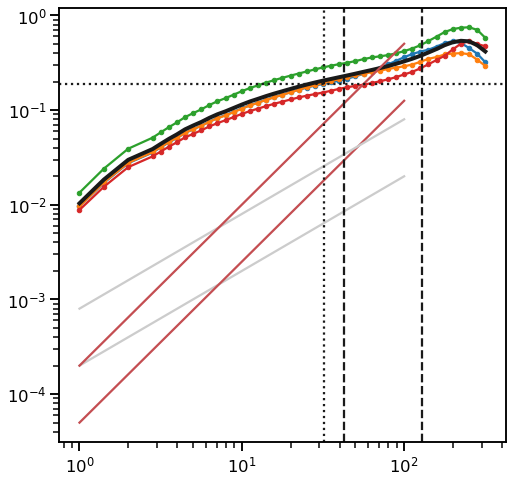

In [12]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

sig2m_np = np.mean(np.stack([_["Unweighted sigma^2"] for _ in sfs_np[0]]), axis=0)


Bs = [_["Unweighted B(r)"][mask] for _ in sfs_np[0]]
Bm0 = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm0, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.0002, 0.0008:
    ax.plot(rgrid, scale * rgrid ** m, color="0.8")
    ax.plot(rgrid, scale*(0.25) * rgrid ** 1.7, color="r")

ax.axhline(sig2m_np, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log",
    yscale="log",
#    ylim=[8e-3, 4],
)

[None, None]

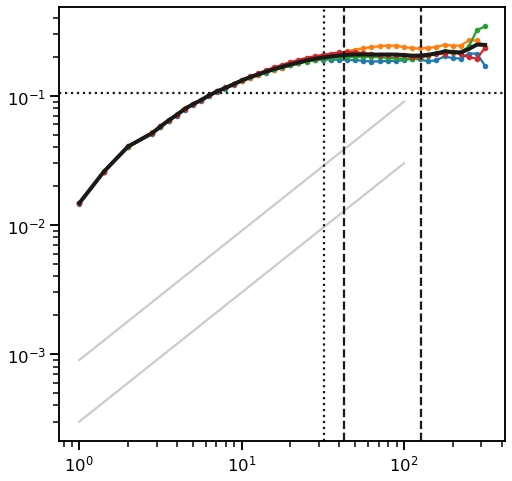

In [13]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)


sig2m = np.mean(np.stack([_["Unweighted sigma^2"] for _ in sfs_npt[0]]), axis=0)

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_npt[0]]
Bm = np.mean(np.stack(Bs), axis=0)


for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.0003, 0.0009:
    ax.plot(rgrid, scale * rgrid ** m, color="0.8")

ax.axhline(sig2m, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log",
    yscale="log",
#    ylim=[8e-3, 4],
)

<ipython-input-14-c7f51490c127>:30: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xscale="log", yscale="log",


[None, (7e-05, 1.9952623149688793), None, (1.0, 256)]

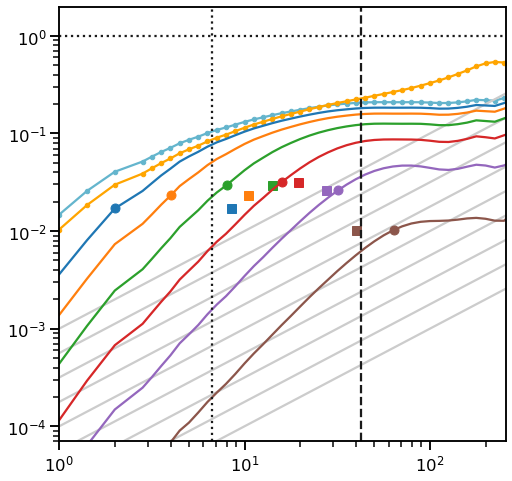

In [14]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)


ax.plot(r, Bm, marker=".", color="c")
ax.plot(r, Bm0, marker=".", color="orange")

true_r0 = np.interp(sig2m, Bm[:-4], r[:-4])

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-5, -3, 9):
    ax.plot(rgrid, a * rgrid ** m, color="0.8")

for width in widths:
    B = np.mean(
        np.stack([_["Unweighted B(r)"][mask] for _ in sfs_npt_s[width]]), axis=0
    )
    line = ax.plot(r, B)
    B0 = np.interp(2 * width, r, B)
    c = line[0].get_color()
    apparent_r0 = np.mean([_["Apparent r0"] for _ in sfs_npt_s[width]])
    ax.plot(2 * width, B0, marker="o", color=c)
    ax.plot(apparent_r0, B0, marker="s", color=c)


ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0, color="k", linestyle="dotted")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="log", 
       xlim=[1.0, N], ylim=[7e-5, 0.0]
      )

In [36]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    x = np.log(rad / (2 * s0))
    y = np.tanh(a * x)
    return 0.5 * (1.0 + y)


def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4 * x ** 2)
    return np.exp(-x)


def seeing_empirical(r, s0, r0, a=0.75):
    return bfac(s0 / r0) * ratio_empirical(r, s0, a)

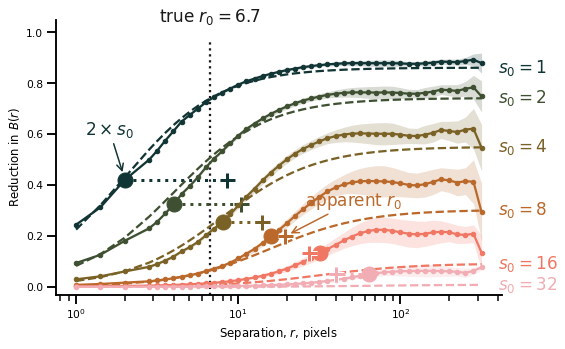

In [39]:
sns.set_context("talk", font_scale=0.65)
#plt.style.use(["seaborn-poster",])

fig, ax = plt.subplots(figsize=(8, 5))
rat_maxes = []
callout_r0_widths = [8]
callout_s0_widths = [1]

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for width, c in zip(widths, colors):
    B = np.mean(
        np.stack([_["Unweighted B(r)"][mask] for _ in sfs_npt_s[width]]), axis=0
    )
    rat = B / Bm
    rat_individs = [
        _this["Unweighted B(r)"][mask] / _B for _this, _B in zip(sfs_npt_s[width], Bs)
    ]
    rat_sigma = np.std(np.stack(rat_individs), axis=0)
    rat_maxes.append(np.max(rat))
    line = ax.plot(r, rat, marker=".", color=c)
    ax.fill_between(
        r,
        rat - rat_sigma,
        rat + rat_sigma,
        color=c,
        alpha=0.2,
        linewidth=0,
    )
    # for _rat in rat_individs:
    #    ax.plot(r, _rat, color=c, alpha=0.2)
    rat0 = np.interp(2 * width, r, rat)
    # c = line[0].get_color()
    ax.plot(2 * width, rat0, marker="o", ms=15, color=c)
    # Functional fit
    ax.plot(r, seeing_empirical(r, width, true_r0, 0.75), color=c, linestyle="dashed")
    # Plot apparent correlation lengths
    apparent_r0 = np.mean([_["Apparent r0"] for _ in sfs_npt_s[width]])
    ax.plot(apparent_r0, rat0, marker="+", ms=15, mew=5, color="w")
    ax.plot(apparent_r0, rat0, marker="+", ms=15, mew=3, color=c)
    ax.plot(
        [2 * width, apparent_r0],
        [rat0] * 2,
        linestyle="dotted",
        color=c,
        linewidth=3,
    )
    ax.text(
        400,
        bfac(width / true_r0),
        fr"$s_0 = {width}$",
        color=c,
        va="center",
        fontsize="x-large",
        alpha=1.0,
    )
    if width in callout_r0_widths:
        ax.annotate(
            "apparent $r_0$",
            xy=(apparent_r0, rat0),
            xytext=(20, 25),
            ha="left",
            va="bottom",
            arrowprops=dict(arrowstyle="->", color=c, shrinkB=6),
            textcoords="offset points",
            fontsize="x-large",
            color=c,
        )
    if width in callout_s0_widths:
        ax.annotate(
            r"$2 \times s_0$",
            xy=(2 * width, rat0),
            xytext=(-40, 40),
            ha="left",
            va="bottom",
            arrowprops=dict(arrowstyle="->", color=c, shrinkB=8),
            textcoords="offset points",
            fontsize="x-large",
            color=c,
        )

ax.axvline(true_r0, ymax=0.93, color="k", linestyle="dotted", zorder=-1)
ax.text(
    true_r0,
    1.1,
    fr"true $r_0 = {true_r0:.1f}$",
    color="k",
    fontsize="x-large",
    ha="center",
    va="top",
)
ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()
fig.savefig("fake-seeing-nonp-3d-ems-fluc_m4-reduction.pdf")

[Text(0, 0.5, 'max B'), None, Text(0.5, 0, 's0')]

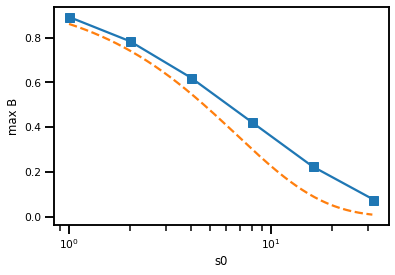

In [38]:
fig, ax = plt.subplots()
ax.plot(widths, rat_maxes, marker="s")
wgrid = np.logspace(0.0, 1.5, 200)
ax.plot(wgrid, bfac(wgrid / true_r0), linestyle="dashed")
#ax.plot(wgrid, bfac2(wgrid / true_r0, a=1.), linestyle="dashed")
ax.set(
    xlabel="s0",
    ylabel="max B",
 #   ylim=[0.0, 1.0],
    xscale="log",
)

In [18]:
#!jupyter nbconvert --to script --no-prompt fake-3d-maps-structure-function-analysis.ipynb

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 9.701345682144165 seconds ---
